#  Multiple linear regression for temperature predictions
## By Eva Bendix Nielsen,
## For master thesis: Predicting Climate with Machine learning

In this study a multiple linear regsression is used to predict the annual winter local temperature for Europe given the global value of total solar irradiance, carbon dioxide and the volcaninc areosol following the procedure of Knudsen et al. (2014).


In [1]:
import numpy as np 
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import pow
from numpy.linalg import matrix_power


Before loading the dataset some initial values needs to be defined.

In [2]:
# Settings 

season = 0 #0 = 13(Winter, DJF), 1= 14(Spring, MAM), 2= 15 (Summer, JJA), 3= 16 (Autumn, SON)
season_shifted = season + 4

test_train_split = 470             # Number of years for training
years            = 500             # Number of years in total
test_years       = 30              # Number of years for testing 
grid_long        = 130             # Longtitudes in grid 
grid_leng        = 70              # Latitudes in grid




Then the data is loaded. The file DATA_DK_1500_2000_DK_GB.csv contains the values for the three cllimate drivers. The data are divided into a test and training set before scaling to hinder bias in the test set. 'TT_Europe_4.csv' contains the temperatures.

In [4]:
# Importing temperature and other prarmeters 

dataset_P = read_csv('DATA_DK_1500_2000_DK_GB.csv', header=None, index_col=0) # Importing climate drivers
dataset_P1 = dataset_P.values
dataset_P1 = np.flip(dataset_P1,0)  # flip the direction from 2000--> 1500 to  1500-->2000
dataset_P1 = dataset_P1[:500,:]     # From 1500 to 1999

data1 = read_csv('TT_Europe_4.csv', delimiter=';', error_bad_lines=False, index_col=0, header=None) # Import temperature data from 1500 to 1999
dataset1 = data1[season:2000:4].values  # From 1500 to 1999

# setting sea values higher 
dataset1 = np.where(dataset1==-999.990, -50, dataset1)  



# Dividing temperature into test and training set
TT_train = dataset1[0:test_train_split, 0:dataset1.shape[1]]
TT_test = dataset1[test_train_split:years, 0:dataset1.shape[1]]

# Dividing climate drivers into test and train
P_train = dataset_P1[:test_train_split,0:3]
P_test = dataset_P1[test_train_split:years,0:3]


print('Dimensions of training set:')
print(TT_train.shape)
print('And of test set: ')
print(TT_test.shape)


Dimensions of training set:
(470, 9100)
And of test set: 
(30, 9100)


The  next step is to scale the temperature and climate drivers individual to a value between 0 and 1 using MinMaxScaler from Scikit-learn.

In [5]:
# Scaling of temperatures
scaler = MinMaxScaler()
scaler = scaler.fit(TT_train) 
TT_scaled_train = scaler.transform(TT_train) 
TT_scaled_test = scaler.transform(TT_test)


# Scaling of climate drivers
scaler1 = StandardScaler()
scaler1 = scaler1.fit(P_train) 
P_scaled_train = scaler1.fit_transform(P_train) 
P_scaled_test = scaler1.transform(P_test)


# reshape temperatures into grid 
TT_train_grid = TT_scaled_train.reshape((test_train_split, grid_leng, grid_long))
TT_test_grid = TT_scaled_test.reshape((test_years, grid_leng, grid_long,))


# Creating the model using a least square inversion
A Matrix G is created consisting of the a row of ones, and then a row containing each of the climate drivers for all training years. The coefficient for the following equation are found by using a least square inversion. 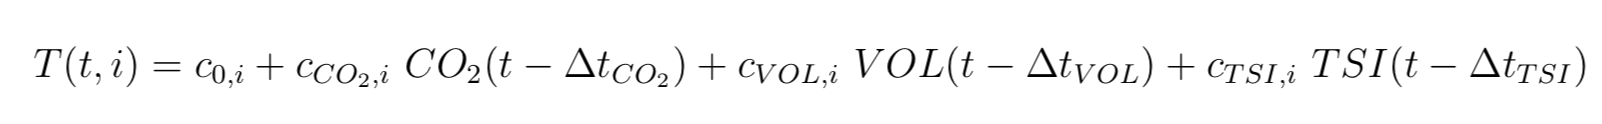

In [6]:
G1 = np.ones((test_train_split,1))
G_global = np.concatenate((G1, P_scaled_train), axis=1)   # 1, CO2, VOl, TSI


# Creating an empty tensor with all 4 coefficient for each grid point
m_coef_global = np.zeros((4,grid_leng,grid_long))   

# Creating an empty tensor for predicted temperatures for each grid point
Temp_global_model = np.zeros((test_years,grid_leng,grid_long))  

A for loop for determening the coefficient and using them to calculate the temperature in each grid has been made. The coefficient are determened using a least square inversion from the equation below: 
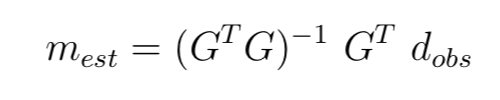

In [7]:
for x in range(grid_leng):
    for y in range(grid_long):
        m_coef_global[:,x,y] =np.dot(np.linalg.inv(np.dot(G_global.T,G_global)),np.dot(G_global.T,TT_train_grid[:,x,y]))
        Temp_global_model[:,x,y] = m_coef_global[0,x,y] + m_coef_global[1,x,y]*P_scaled_test[:,0] + m_coef_global[2,x,y]*P_scaled_test[:,1]+ m_coef_global[3,x,y]*P_scaled_test[:,2]


# Rescaling and plotting the temperature 
The temperature are now rescaled an plotted for the predicted time interval.

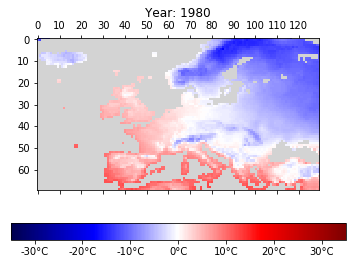

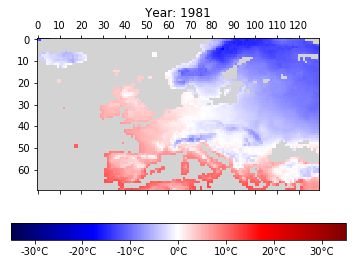

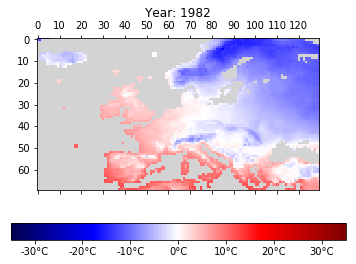

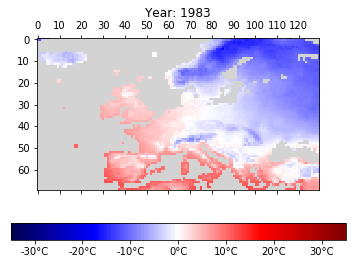

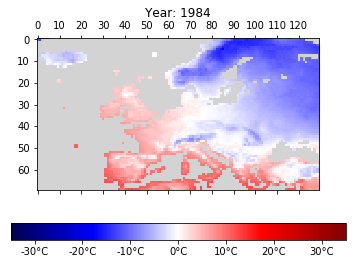

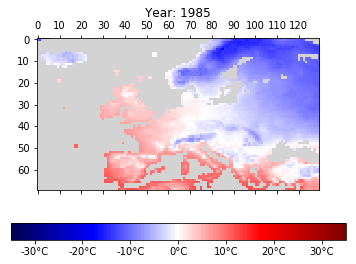

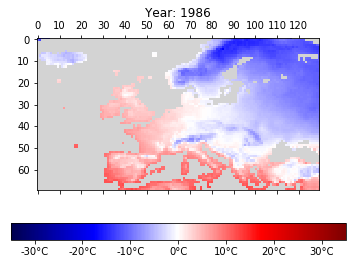

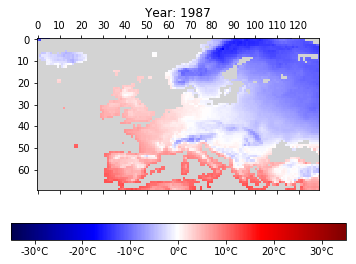

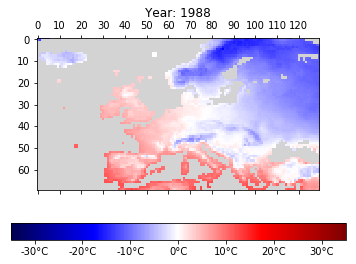

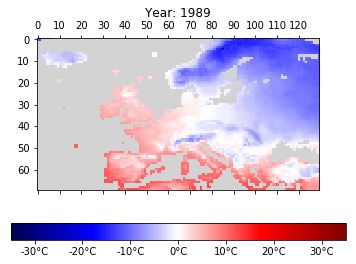

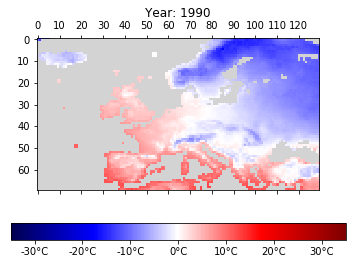

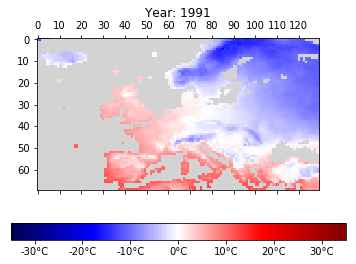

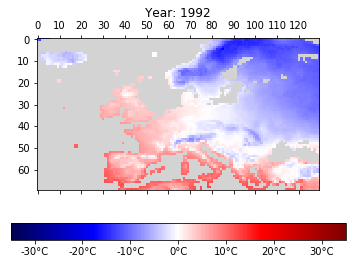

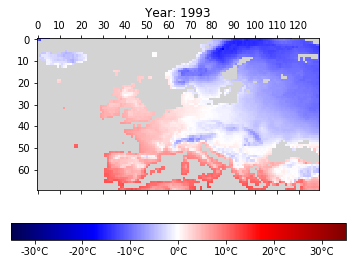

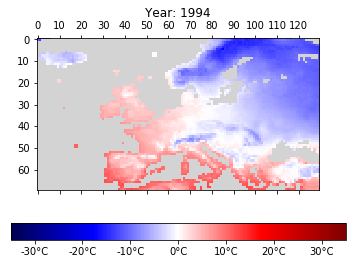

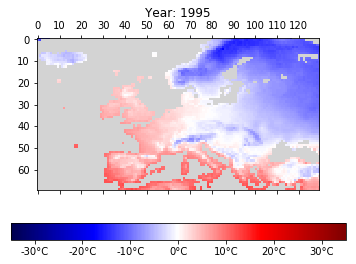

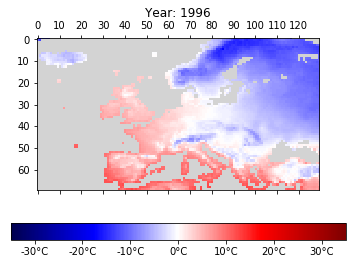

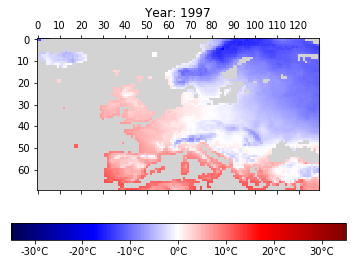

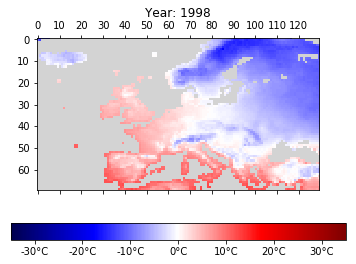

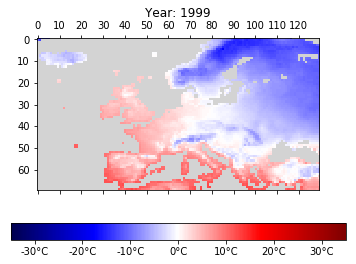

In [8]:

Temp_global_model = np.where(TT_train_grid[:30,:,:]==0, -50, Temp_global_model)


Temp_global_model_re=Temp_global_model.reshape(30,9100)   # shape back to rows and columns 

Temp_global_model_re1= scaler.inverse_transform(Temp_global_model_re)              # Rescale 
Temp_global_model_Final =Temp_global_model_re1.reshape(30,70,130)
            


cmap = pyplot.cm.seismic            # Colorscale 
cmap.set_under('lightgrey') 

for x in range(20):
    fig, ax = pyplot.subplots()
    min_val, max_val = -35, 35
    intersection_matrix = Temp_global_model_Final[x,:,:]     # Plot
    cax = ax.matshow(intersection_matrix, cmap=cmap, vmin=-35, vmax=35  ) 
    ax.set_title('Year: '+str(x+1980), y=1.10)    
    pyplot.locator_params(axis='y', nbins=7)
    pyplot.locator_params(axis='x', nbins=13)
    cbar = fig.colorbar(cax, ticks=[-30,-20,-10, 0,10, 20, 30,], orientation='horizontal')
    cbar.ax.set_xticklabels(['-30°C','-20°C','-10°C','0°C','10°C', '20°C', '30°C'])